In [1]:
###### Config #####
import sys, os, platform
if os.path.isdir("ds-assets"):
  !cd ds-assets && git pull
else:
  !git clone https://github.com/lutzhamel/ds-assets.git
colab = True if 'google.colab' in os.sys.modules else False
system = platform.system() # "Windows", "Linux", "Darwin"
home = "ds-assets/assets/"
sys.path.append(home)  

Already up to date.


In [2]:
# notebook level imports
import random
import dsutils  # regression_confint
import pandas as pd
import seaborn as sns; sns.set_theme()
from sklearn import linear_model       # LinearRegression
from sklearn import tree               # DecisionTreeRegressor
from sklearn import neighbors          # KNeighborsRegressor
from sklearn import neural_network     # MLPRegressor
from sklearn import model_selection    # GridSearchCV



In [3]:
# generate a regression data set with noise
def gen_regression_data(m=2, b=-1, n=50, y_range=30):
   """
   # model parameters!
   m = 2        # slope
   b = -1       # intercept
   # data set specs
   n = 50       # number of points to generate
   y_range = 30 # governs the level of noise on the y coordinate"
   """
   delta_y = \
   pd.Series([random.uniform(-y_range,y_range) for _ in range(n)])

   # generate a dataframe for our data points
   # generate values on the x-axis
   x = pd.DataFrame({'x':[i for i in range(n)]})
   # generate values on the y-axis using x-values
   y = pd.DataFrame({'y': m * x['x'] + b + delta_y})
   # each row represents the point (x,y)
   points_df = pd.concat([x,y], axis=1)
   return points_df

# Regression

* In regression we predict **values** rather than discrete labels.
* In the simplest case we want to fit a line through a set of points - **simple linear regression**.

A straight-line is a model of the form,

$y=mx+b$

where m is the *slope* and b is the *intercept*.  


<img src="https://raw.githubusercontent.com/lutzhamel/ds-assets/main/assets/linreg-scatter.png"  
height="200" 
width="225">

[source](https://towardsdatascience.com/mathematics-hidden-behind-linear-regression-431fe4d11969)





## Example

Let's try this with a synthetic data set.

In [4]:
# n is the number of points to generate
# y_range constrols the level of noise on the y coordinate
points_df = gen_regression_data(n=50, y_range=30) 
points_df.head()  


,x,y
0,0,-14.788222
1,1,-26.473425
2,2,-10.718298
3,3,-3.907007
4,4,36.312873


<Axes: xlabel='x', ylabel='y'>

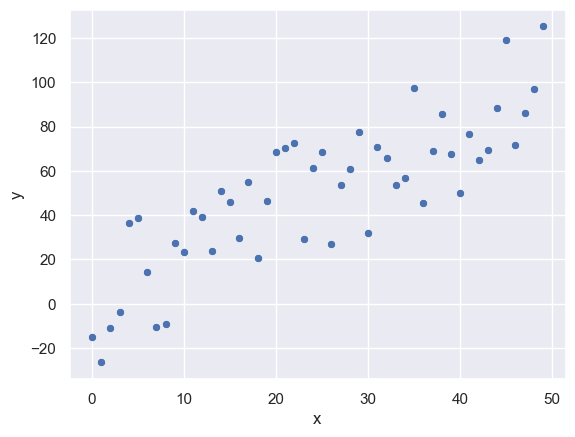

In [5]:

sns.scatterplot(data=points_df, x='x', y='y') 

In [6]:
# regression training data
X = points_df[['x']]
y = points_df['y']

Linear regression does not have any free parameters -- **no search**!

In [7]:
# linear regression model
model = linear_model\
   .LinearRegression()\
   .fit(X, y)

In [8]:
dsutils.rs_score(model, X, y, as_string=True)  # R^2 score

'R^2 Score: 0.69 (0.55, 0.83)'

<Axes: xlabel='x', ylabel='y'>

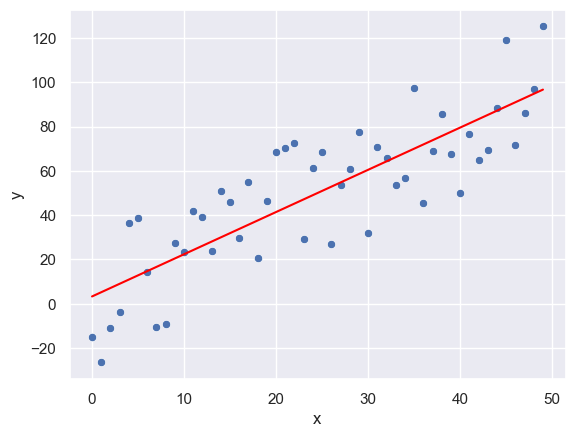

In [9]:
# plot the model together with the data
sns.scatterplot(x=X['x'], y=y)  # data
sns.lineplot(x=X['x'], y=model.predict(X), color='red')  # model

**Demo**: Play with the noise in the data and watch the $R^2$ score.

# Another Look at the $R^2$ Score

* The $R^2$ score is a score that compares the errors squared of the regression model to the errors squared of a default model.

* The default model is just the average value $\bar{y}$ of all y-values.  That is, for any x-value the model always returns the same answer: $\bar{y}$.

<img src="https://raw.githubusercontent.com/lutzhamel/ds-assets/main/assets/rs.png" height="400" width="460">

(Source: [Wikipedia](https://en.wikipedia.org/wiki/Coefficient_of_determination))



**Note**: The name $R^2$ comes from the fact that we **square** the residuals $R$.

## The Mathematics of $R^2$

Let's explore that figure a little bit more assuming that we have a training dataset that consists of the set of points,

$$\{(x_1,y_1), (x_2,y_2),\dots,(x_n,y_n)\}$$

where $x_i$ are the values of the independent variable and $y_i$ are the values of the dependent variable. Then the we have the following definitions,

1. The **default model** is defined as 
   $$\bar{y} = \frac{1}{n}\sum_{i=1}^n y_i,$$ 
   the average of the expected outcomes $y_i$ of the training data.
1. The regression model is $f$ and the **residuals**, $r_i$, are defined as 
   $$r_i = y_i - f(x_i)$$
    for $i=1\ldots n$, that is, the residual $r_i$ is the difference between the expected outcome $y_i$ at point $x_i$ minus the outcome computed by the model $f(x_i)$.
1. $SS_{\rm res}$ is the squared sum of the residuals of the model $f$, more precisely, 
   $$SS_{\rm res} = \sum_{i=1}^n r_i^2 = \sum_{i=1}^n (y_i - f(x_i))^2$$
1. $SS_{\rm tot}$ is the squared sum of the residuals of the default model $\bar{y}$, more precisely, 
   $$SS_{\rm tot} = \sum_{i=1}^n (y_i - \bar{y})^2$$

With these definitions we can now compute the $R^2$ score as

$$R^2
= 1 - \frac{SS_{\rm res}}{SS_{\rm tot}}
= 1 - \frac{\sum_{i=1}^n (y_i - f(x_i))^2}{\sum_{i=1}^n (y_i - \bar{y})^2}
$$

Notice that if the performance of our regression model $f$ approaches the performance of our default model $\bar{y}$ then the
score will be,

$$R^2 \approx 1 - 1 = 0$$

If our model $f$ is perfect, that is, all residuals $y_i - f(x_i)$ are equal to zero then we obtain the score,

$$R^2 = 1 - 0 = 1$$

**Conclusions**
* The closer an $R^2$ score is to one the better the model.  
* It turns out that if our model $f$ is worse than the default model $\bar{y}$ then it is possible to obtain negative $R^2$ values.

# ANN/MLP Regression Models

We'll look at MLP regression models.

* In MLP regression we ask the network to model a continuous value.  
* This turns out to be just a change in interpretation of the output value.  
* Rather than applying a thresholding function to the output like the 'sign' function we just use the raw output value as the model output value.


In [10]:
# get our dataset
cars_df = pd.read_csv(home+"cars.csv")
X = cars_df[['speed']]
y = cars_df['dist']

## Rule of Thumb MLP
Let's build a MLP regressor using our rule of thumb neural network construction.

* Technically we should use N=2 since there is only 1 independent variable.  
* That seems a bit low, so we'll use N=4.

In [11]:
N=4

In [12]:
# MLP regression model
model = neural_network\
   .MLPRegressor(
      hidden_layer_sizes=(N,), # rule of thumb architecture
      activation='logistic',  
      max_iter=100000, # max iterations to train the model
      )\
   .fit(X,y)

In [13]:
dsutils.rs_score(model, X, y, as_string=True)  # R^2 score

'R^2 Score: 0.71 (0.58, 0.84)'

<Axes: xlabel='speed', ylabel='dist'>

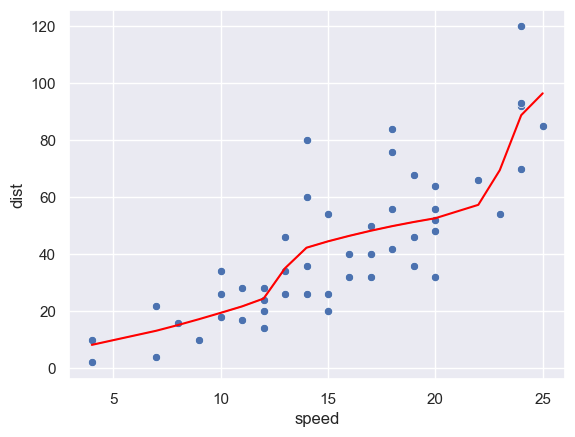

In [14]:
# plot the model
sns.scatterplot(x=X['speed'], y=y)
sns.lineplot(x=X['speed'], y=model.predict(X), color='red') #model

## Grid Search MLP



In [25]:
# neural network object
model = neural_network.MLPRegressor(max_iter=100000, 
                                    activation='logistic',
                                    random_state=1)

# grid search:
#   * limit to 1 and 2 hidden layers
#   * vary number of neurons in each layer (multiples of 2 of N)
#   * vary activation functions
param_grid = {
    # search over different architectures
    'hidden_layer_sizes':
      [
      # single layer MLP: vary size by N with multipliers of 2
      (N//2,), (N,), (N*2,),
      
      # 2 layers: first fixed at N/2, second varying
      (N//2,N//2), (N//2, N), (N//2, N*2),
      
      # 2 layers: first fixed at N, second varying
      (N, N//2), (N,N), (N, N*2),
      
      # 2 layers: first N*2, second varying
      (N*2, N//2), (N*2, N), (N*2, N*2)
      ],
}

# perform grid search
grid = model_selection.GridSearchCV(model, param_grid, cv=3).fit(X, y)
best_params = grid.best_params_
best_model = grid.best_estimator_

print(f"Grid Search: best parameters: {best_params}")

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100000) reached and the optimization hasn't converged yet.
  warnings.warn(


Grid Search: best parameters: {'hidden_layer_sizes': (4, 4)}


In [26]:
dsutils.rs_score(best_model, X, y, as_string=True)  # R^2 score

'R^2 Score: 0.75 (0.63, 0.86)'

<Axes: xlabel='speed', ylabel='dist'>

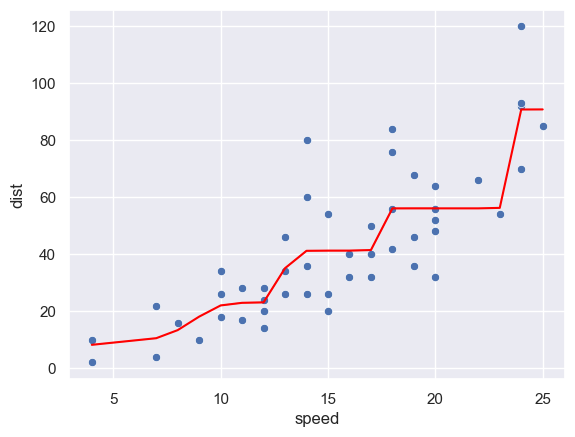

In [27]:
# plot the model
sns.scatterplot(x=X['speed'], y=y)
sns.lineplot(x=X['speed'], y=best_model.predict(X), color='red') #model

**Observation**: Again, the performance of our 'rule of thumb' MLP is not statistically different from the optimal grid search model.

# Regression Trees

* Let's take another look at regression trees.
* We build a default regression tree.

In [28]:

# regression trees
model = tree.DecisionTreeRegressor().fit(X,y)

In [29]:
dsutils.rs_score(model, X, y, as_string=True)  # R^2 score

'R^2 Score: 0.79 (0.69, 0.89)'

<Axes: xlabel='speed', ylabel='dist'>

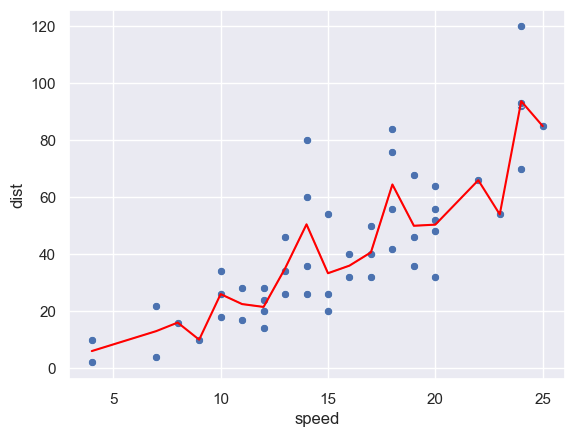

In [31]:
# plot the model
sns.scatterplot(x=X['speed'], y=y)
sns.lineplot(x=X['speed'], y=model.predict(X), color='red') #model

## Regression and Grid Search: Tree Regression

Just like in classification, regression models are built using a small sample of a possibly infinite data universe and we have to estimate the model parameters for the best model using this small sample. That means we have to perform a grid search over parameter ranges and we want to use cross-validation to minimize the bias of any one particular training-test split of the data.

Let's try this with tree regression. We still use the car data set from the previous section.

In [32]:
# setting up grid search
model = tree.DecisionTreeRegressor()
param_grid = {
   'max_depth': list(range(1,11))
   }
best_model = model_selection\
   .GridSearchCV(model, param_grid)\
   .fit(X,y)\
   .best_estimator_

In [33]:
dsutils.rs_score(best_model, X, y, as_string=True)  # R^2 score

'R^2 Score: 0.76 (0.66, 0.87)'

<Axes: xlabel='speed', ylabel='dist'>

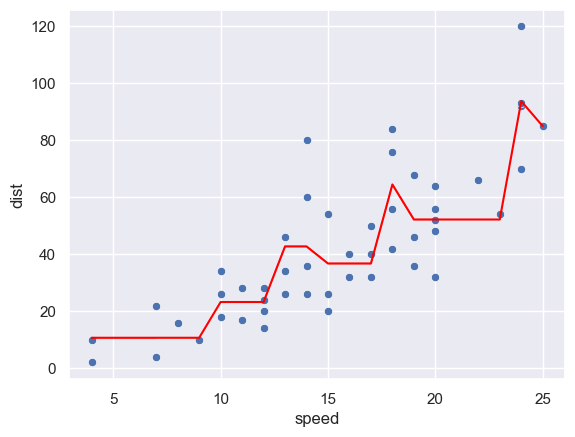

In [34]:
# plot the model
sns.scatterplot(x=X['speed'], y=y)
sns.lineplot(x=X['speed'], y=best_model.predict(X), color='red') #model

**Observation**: 
* There is no statistical difference between the performance of the default model and the best model.  
> Default regression models tend not to overfit in the same sense that classification models do!
* Therefore in regression is it ok to use the default models, except for MLPs where we want to use the 'rule of thumb' model